# Smoothed Model Checking using GPC

Goal: estimate satisfaction function of a formula from instances of its satisfaction on individual runs at discrete parameter values  

Find statistical estimate of satisfaction probability $\varphi$ as function of uncertain parameters $\theta$, i.e. of the satisfaction function $f_{\varphi}(\theta) = P(\varphi | M_{\theta})$.  

Given: sample trajectories on a few input points, where we can observe the satisfaction $f_{\varphi}$.  

We want to compute an estimate of $f_{\varphi}(\theta *)$ together with a confidence interval for all possible values of $\theta$.  


Use **Gaussian Process Classification** to estimate the satisfaction function, because we have true/false labels per input point (= classification). Prior can be combined with likelihood models for the observations in a Bayesian fashion to yield a joint posterior.  


In [79]:
import os
import numpy as np
import numpy.matlib
import math
from scipy.stats import norm
from scipy.special import erf 
# scipy gives upper triangular matrix, numpy lower
from scipy.linalg import cholesky
import subprocess
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline

# Kernel  

Place GP prior over latent function $f(x)$ and squash it with inverse probit transformation to get probabilities from real values, so to get the prior on $\pi(x) = p(y=1|x) = \phi(f(x))$.  

Popular kernel: **radial basis function** (or squared exponential): $$k(x,x')= \sigma^2 exp(- \frac{(x-x')^2}{2\lambda^2}) $$

The **inverse probit function** is equal to the standard normal cumulative distribution function (cdf): 
$$ \Phi(z) = \int_{-\infty}^z \mathcal{N}(x|0,1) dx = \frac{1}{2} + \frac{1}{2} \cdot erf \left( \frac{x}{\sqrt{2}} \right),  $$

where $erf$ is the Gauss error function, defined as $erf(z) = \frac{2}{\sqrt{\pi}} \int_0^z e^{-t^2}~ dt$. 


We set a zero-mean Gaussian prior for f: $p(f|X) = \mathcal{N}(f|0,K)$ and sample five functions.

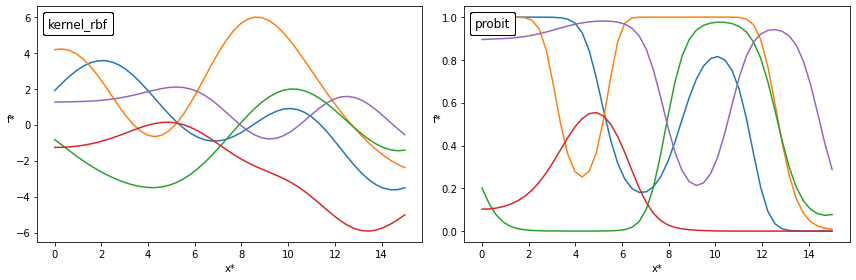

In [80]:
def kernel_rbf(x, y, param):
    """ Radial Basis Function Kernel 
    
    Args:
        x: First input vector of kernel (N,1)
        y: Second input vector of kernel (N,1)
        param: Hyperparameter of kernel: scale factor variance and lengthscale ell
        
    Returns:
        Covariance matrix of each pairwise combination of set of points
    """
    variance = param['var']
    lengthscale = param['ell']
    # Euclidean distance between points
    eucdist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T)
    return variance * np.exp(-0.5 * eucdist * 1/(lengthscale**2))



# define default hyperparameters for kernel
params = {'var': 7,
          'ell': 3}

# Test Data: N points from 0 to 15
N_s = 50
X_s = np.linspace(0, 15, N_s).reshape(-1,1)

# Prior using RBF 
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# compute mean and covariance
mu_prior = np.zeros(X_s.shape)
cov_prior = kernel_rbf(X_s, X_s, params)
# sample 5 normals from GP prior and plot
f_prior = np.random.multivariate_normal(mu_prior.ravel(), cov_prior, 5)
for sample in f_prior:
    ax[0].plot(X_s, sample, lw=1.5, ls='-')
    #plt.title(f'Prior using {kernel_rbf.__name__}')
    at = AnchoredText('kernel_rbf', prop=dict(size=12), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[0].add_artist(at)
    ax[0].set_xlabel('x*')
    ax[0].set_ylabel('f*', rotation=0)
#plt.subplot(1, 2, 2)
for sample in f_prior:
    ax[1].plot(X_s, norm.cdf(sample), lw=1.5, ls='-')
    #plt.title(f'Prior with probit transformation')
    at = AnchoredText('probit', prop=dict(size=12), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[1].add_artist(at)
    ax[1].set_xlabel('x*')
    ax[1].set_ylabel('f*', rotation=0)
plt.tight_layout()        
plt.show()
#fig.savefig('../figures/other/smmc_priors.png', dpi=300)


## Likelihood model   
Observations are made through *boolean* evaluations of a formula over individual trajectories at some parameter values. It is not possible to directly apply Gaussian observation noise, therefore a closed form solution cannot be found, only an approximation of the posterior. The satisfaction of a formula $\varphi$ over a trajectory generated from a specific parameter value $\theta$ is a Bernoulli random variable with success probability $f_{\varphi}(\theta)$. We can map this probability to the real numbers with the *inverse probit transformation*. 



## Inference problem 
We have *D* binary evaluations of satisfaction at each of $P$ parameter values. At each parameter value, these evaluations represent individual draws from the same *Bernoulli* distribution with success probability $f_{\varphi}(\theta)$. The transform of this success probability is a smooth function over the (unknown) parameters and is assigned a GP prior. The *overall joint probability* of observations $O$ and of the satisfaction function would be:  

$p(O,f_{\varphi}(\theta)) = GP ( \psi (f_{\varphi}(\theta))) \prod^D \prod^P \text{Bernoulli} (O_{ij} | f_{\varphi}(\theta_j))$

## Posterior  
Computing the posterior introduces an *approximation* (non-Gaussian likelihood makes integral intractable) $\rightarrow$ use **Expectation Propagation** algorithm to efficiently compute the approximate posterior.

<!-- ## Inference

2 steps:  
- compute distribution of latent variable corresponding to a test case: $p(f_*|X,y,x_*) = \int p(f_*|X,x_*,f) p(f|X,y) df$, where $p(f|X,y) = p(y|f)p(f|X)/p(y|X)$ is the posterior over the latent variables      

   
     
- use this distribution over latent $f_*$ to produce probabilistic prediction: $\overline{x}_* = p(y_*=1|X,y,x_*) = \int \sigma(f_*)p(f_*|X,y,x_*)df$   
-->


## Expectation Propagation (EP)

**EP** computes a Gaussian approximation to probabilistic models of the form $p(x|y) = p_0(x) \prod_i t_i(y_i,x_i)$,  where $p_0$ is the prior multivariate Gaussian distribution, and $t_i$ the non-Gaussian observation likelihood.    
The likelihood terms are replaced by univariate Gaussian terms: $q(x|y) = p_0(x) \prod_i \tilde{t_i} (y_i,x_i)$



<!-- ### 2) Perform smoothed model checking (SMC 65)

getAnalyticApproximation(data, parameters, options)  
-> optimize hyperparameters for rbf kernel or take default ones  
-> doTraining = probit gp regression  
   -> expectationPropagation
   
then return performSmoothedModelChecking(approx, parameters, options) -->

### Helper functions for EP  

**Marginal moments** $\mu$ and $\sigma^2$  



**Rasmussen 3.53:**. 

$q(f|X,y) \overset{\Delta}{=} \frac{1}{Z_{EP}} p(f|X) \prod t_i(f_i| \tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \mathcal{N}(\mu,\Sigma)$   

with $Z_{EP}=q(y|X)$,   

$\mu=\Sigma\tilde{\Sigma}^{-1}\tilde{\mu}$, $\tilde{\Sigma}$ is diagonal with $\tilde{\Sigma}_{ii} = \tilde{\sigma}_i^2$   

$\Sigma=(K^{-1}+\tilde{\Sigma}^{-1})^{-1}$   



**Here:**  


! Attention: computation of cholesky(A) may fail when A is not PD (for large amplitudes)




(Note: Cholesky returns $L'$ for $A = L * L' $)    

$L = (cholesky({LC}' * (\tilde{\tau} * {LC}) + I))'$  

$L * W = LC' \rightarrow$ Solve for $W$: $W = L^{-1} * LC'$   

$diagV = diag(W' * W)$  

$m = W' * (W * \tilde{v})$  

$logdet = -2 * \sum \log(diag(L)) + 2 * \sum \log(diag(LC))$  

$logZappx = \frac{1}{2} (m' * \tilde{v} + logdet)$



Note:   
$\tilde{v} = \tilde{\mu} \tilde{\sigma}^{-2} = \tilde{\mu} * \tilde{\tau} $  
$\tilde{\tau} = \tilde{\sigma}^{-2}$  


In [81]:
def marginal_moments(Term, gauss_LC, gauss_LC_t):
    """
    Computes marginal moments
    
    Args:
        Term: v_tilde, tau_tilde (datapoints, 2)
        gauss_LC: lower-triangular of prior covariance
        gauss_LC_t: transpose of lower-triangular
        
    Returns:
        logZappx: 
        gauss_m: mu (datapoints,1)
        gauss_diagV: diagonal of sigma^2 (datapoints,1)
    """
    
    # A = LC' * (tau_tilde * gauss_LC) + I 
    tmp = np.multiply(Term[:,1], gauss_LC)
    A = np.matmul(gauss_LC_t, tmp) + 1 * np.eye(datapoints)
    gauss_L = cholesky(A).T  

    # W = L\LC' -> Solve L*W = LC'
    gauss_W = np.linalg.solve(gauss_L, gauss_LC_t)
    gauss_diagV = np.diagonal(np.matmul(gauss_W.T, gauss_W)).reshape(-1,1)
    
    # m = W'*(W * v_tilde)
    tmp = np.matmul(gauss_W, Term[:,0])
    gauss_m = np.matmul(gauss_W.T, tmp).reshape(-1,1)

    # logdet = -2*sum(log(diag(L))) + 2*sum(log(diag(LC)))
    logdet = -2*np.sum(np.log(np.diagonal(gauss_L))) # + 2*np.sum(np.log(np.diag(gauss_LC))) (das ist schon logdet_LC)
    logdet += logdet_LC

    # logZappx = 1/2(m' * v_tilde + logdet)
    logZappx = 0.5 * (np.dot(gauss_m.T, Term[:,0]) + logdet)

    return logZappx, gauss_m, gauss_diagV

https://en.wikipedia.org/wiki/Gauss–Hermite_quadrature  

**Gauss-Hermite quadrature** is a form of Gaussian quadrature for approximating the value of integrals of the following kind:  

$ \int_{-\infty}^{+\infty} e^{-x^2} f(x) dx \approx \sum_{i=1}^n w_i f(x_i)  $  

where $n$ is the number of sample points used (here: nodes). The $x_i$ are the roots of the physicists' version of the Hermite polynomial $H_n(x)$ and the associated weights $w_i$ are given by:  

$ w_i = \frac{ 2^{n-1} n! \sqrt{\pi}}{n^2 [H_{n-1}(x_i)]^2}$   


Binary classification: determining moments of tilted distribution requires solving only 1-dimensional integrals; assuming probit likelihood functions $\rightarrow$ univariate integrals can be computed efficiently without quadrature. But here: need quadrature because we have multiple observations per input point


In [82]:
def gausshermite(nodes):
    """
    Gauss-Hermite 
    https://indico.frib.msu.edu/event/15/attachments/40/157/Gaussian_Quadrature_Numerical_Recipes.pdf
    
    Approximate integral of a formula by the sum of its functional values at some points
    
    Args:
        nodes: number of Gauss-Hermite nodes (96,1)
        
    Returns:
        x0: abscissas (96,1)
        w0: weights (96,1)
    """

    x0 = np.zeros((nodes, 1))
    w0 = np.zeros((nodes, 1))
    m = int((nodes+1)/2)
    z,pp,p1,p2,p3 = 0,0,0,0,0
    
    for i in range(m):
        if i==0:
            z = np.sqrt(2*nodes+1) - 1.85575 * ((2*nodes+1)**(-0.166667))
        elif i==1:
            z = z - 1.14 * (nodes**0.426) / z
        elif i==2:
            z = 1.86 * z - 0.86 * x0[0]
        elif i==3:
            z = 1.91 * z - 0.91 * x0[1]
        else:
            z = 2.0 * z - x0[i - 2]

        for its in range(10):
            p1 = 1/np.sqrt(np.sqrt(np.pi))
            p2 = 0
            for j in range(1,nodes+1):
                p3=p2
                p2=p1
                a = z*np.sqrt(2/j)*p2
                b = np.sqrt((j-1)/j)*p3
                p1=a-b
            pp=np.sqrt(2*nodes)*p2
            z1=z
            z=z1-p1/pp
            if np.abs(z-z1)<2.2204e-16:
                break

        x0[i] = z
        x0[nodes-1-i] = -z
        w0[i] = 2/(pp*pp)
        w0[nodes-1-i] = w0[i]

    w0 = np.divide(w0, np.sqrt(np.pi))
    x0 = np.multiply(x0, np.sqrt(2))
    x0 = np.sort(x0, axis=None).reshape(-1,1)
    
    return x0, w0

Compute **new posterior marginal moments** $\hat{\mu}$ and $\hat{\sigma}^2$   

Find new Gaussian marginal which best approximates the product of the cavity distribution and the exact likelihood $\hat{q}(f_i) \overset{\Delta}{=} \hat{Z}_i ~ \mathcal{N}(\hat{\mu}_i, \hat{\sigma}^2_i) \simeq q_{-i} (f_i) p (y_i | f_i) $.  

It is well known that distribution $q(x)$ which minimizes KL$(p(x)||q(x))$ is the one whose first and second moments match that of $p(x)$. <!--$\hat{q}(f_i)$ is unnormalized, so choose additionally the condition that zero-th moments (normalizing constants) should match when choosing the parameters of $\hat{q}(f_i)$ to match the right-hand side of above equation.-->  
Derivation of moments is complicated (see Appendix 3.9). Desired posterior marginal moments are:  

**Rasmussen 3.58:**  

$ \hat{Z} = \Phi (z)$  

$ \hat{\mu} = \mu_{-i} + \frac{y ~ \sigma^2_{-i} \mathcal{N}(z)} { \Phi(z) \sqrt{1 + \sigma^2_{-i}}} $  

$ \hat{\sigma}^2 = \sigma^2_{-i} - \frac{ \sigma^4_{-i} \mathcal{N}(z)} {(1 + \sigma^2_{-i}) \Phi (z) } (z + \frac{\mathcal{N}(z)} {\Phi (z)} ) $,  


where $z = \frac{y ~ \mu_{-i}} { \sqrt{1 + \sigma^2_{-i}} } $  


Here:  

$G = \text{logprobitpow}((\sigma_{-i} * xGH + \mu_{-i}), p, q) + logwGH'$, $G = G - \max(G)$ for each datapoint   

**Gauss-Hermite** to match distribution https://www.wouterdenhaan.com/numerical/integrationslides.pdf 
Get $n$ nodes ($xGH$) and weights ($logwGH$) from function *gausshermite*. Expectation of normally distributed variable: $E[h(y)]$ with $y \sim \mathcal{N}(\mu,\sigma^2)$.  
Calculate $\int_{-\infty}^{\infty} \frac{1}{\sigma \sqrt{2 \pi}} h(y) \exp(- \frac{(y-\mu)^2}{2\sigma^2})dy$  
$\rightarrow$ do a trick with change of variables and transformation, then approximation is:  

$E[h(y)] \approx \sum_{i=1}^n \frac{1}{\sqrt{\pi}} w_i h(\sqrt{2} \sigma x_i + \mu)$

$\rightarrow$ this relates to $ \text{logprobitpow}((\sigma_{-i} * xGH + \mu_{-i}), p, q) + logwGH'$, because nodes $x_i$ are already multiplied by $\sqrt{2}$ and weights $w_i$ are already divided by $\sqrt{\pi}$ in *gausshermite*. Since we're taking the logarithm, we have $\log x \cdot y = \log x + \log y$, so $+ logwGH$ in $G$ instead of $\cdot w_i$.   


$logZ = maxG + \log(\sum e^G)$  

Moments:  

$\hat{\mu} = \mu_{-i} + \Delta_m \rightarrow \Delta_m = \frac{\sigma_{-i} * (e^G * xGH)}{\sum e^G} $  

$\hat{\sigma}^2 = \frac{\sigma_{-i}^2 * (e^G * xGH^2)}{\sum e^G} - \Delta_m^2$  

$logZ = \max(G) + \log(\sum \exp(G - \max(G))) = \log \sum \exp(G)$ is smooth approximation to get largest element of $G$. 

In [83]:
def GaussHermiteNQ(FuncPar_p, FuncPar_q, cav_m, cav_v, xGH, logwGH):
    """
    Gauss-Hermite numerical quadrature for moment computation
    
    Args:
        FuncPar_p: number of runs satisfying property for each parameter value (input) (datapoints,1)
        FuncPar_q: number of runs not satisfying property (datapoints,1)
        cav_m: cavity mean mu_-i
        cav_v: cavity variance sigma^2_-i
        xGH: abscissas (Gauss-Hermite)
        logwGH: weights (Gauss-Hermite)
        
    Returns:
        logZ: largest element of expectation of normally distributed variable?
        Cumul: mu_hat, sigma^2_hat (datapoints,2)
    """
    
    Nnodes = len(xGH)
    
    # sigma_-i
    stdv = np.sqrt(cav_v).reshape(-1,1)

    Y = np.matmul(stdv, xGH.reshape(1,-1)) + numpy.matlib.repmat(cav_m, 1, Nnodes)        
    G = np.array(logprobitpow(Y, FuncPar_p, FuncPar_q) + numpy.matlib.repmat(logwGH.T, datapoints, 1))
        
    # maximum of each row (input value) over all 96 nodes
    maxG = G.max(axis=1).reshape(-1,1)
    # subtract maximum value
    G = G - np.matlib.repmat(maxG, 1, 96)
    # exponential value
    expG = np.exp(G)
    # denominator (row sum)
    denominator = expG.sum(axis=1).reshape(-1,1)
    logdenominator = np.log(denominator)
    logZ = maxG + logdenominator
    
    Cumul = np.zeros((len(FuncPar_p), 2))

    # deltam = stdv * (expG * xGH) / denominator
    deltam = np.divide(np.multiply(stdv, np.matmul(expG, xGH)), denominator)

    # mu_hat = mu_-i + deltam    
    Cumul[:,0] = (cav_m + deltam).reshape(-1)
    
    xGH2 = xGH**2
    deltam2 = deltam**2

    # sigma^2_hat
    Cumul[:,1] = (np.divide(np.multiply(cav_v, np.matmul(expG, xGH2)), denominator) - deltam2).reshape(-1)
        
    return logZ, Cumul

Compute **cavity parameters** $\mu_{-i}$ and $\sigma^2_{-i}$   

**Rasmussen 3.56:**   


$cav_m = \mu_{-i} = \sigma_{-i}^2 \cdot ( \frac{\mu}{\sigma^2} - \frac{\tilde{\mu}}{\tilde{\sigma}^2} )$   



$cav_v =  \sigma_{-i}^2 = \frac{1}{\sigma^{-2} - \tilde{\sigma}^{-2}}  $   


**Here:** $diagV = \sigma^2$ and $\tilde{\tau} = \tilde{\sigma}^{-2}$ and $\tilde{v} = \tilde{\mu} \tilde{\sigma}^{-2}$; transforming the equations shows that they're equal:      

$cav_m = \frac{m + (- \tilde{v} \cdot diagV) }{1 + (- \tilde{\tau} \cdot diagV)} = \frac{ \mu - \tilde{\sigma}^{-2} \tilde{\mu} \sigma^2}{1 - \tilde{\sigma}^{-2} \sigma^2} $   


$cav_{diagV} = \frac{diagV}{1 + (- \tilde{\tau} * diagV)} = \frac{1}{diagV^{-1} - \tilde{\tau}} = \frac{1}{\sigma^{-2} - \tilde{\sigma}^{-2}}$   


The cavity distribution combines the prior and the local likelihood approximations; afterwards, it is combined with the exact likelihood for case $i$. To do so, we remove the approximate likelihood $i$ from the approximate posterior by dividing the marginal with the approximate term $t_i$.  
$q_{-i}(x) = \frac{q(x)}{\tilde{\tau}_i(x)}$

In [84]:
def cavities(gauss_diagV, gauss_m, Term):
    """
    Compute cavity distribution by removing the effect of a single factor from q
    
    Args:
        gauss_diagV: sigma^2
        gauss_m: mu
        Term: v_tilde, tau_tilde (datapoints,2)
        
    Returns:
        cav_m: cavity mean mu_-i
        cav_diagV: cavity variance sigma^2_-i
    """
    
    # s = 1 / (1 + -tau_tilde * diagV)
    s = np.divide(1, (1 + np.multiply(-Term[:,1].reshape(-1,1), gauss_diagV)))

    # cav_diagV = s * diagV
    cav_diagV = np.multiply(s, gauss_diagV)
    
    # cav_m = s * (m + (-v_tilde * diagV))
    cav_m = np.multiply(s, (gauss_m + np.multiply(-Term[:,0].reshape(-1,1), gauss_diagV)))
    
    return cav_m, cav_diagV
        

Update **site parameters** $\tilde{v}$ and $\tilde{\tau}$ with new posterior marginal moments $\hat{\mu}$ and $\hat{\sigma}^2$.  

Final step is to compute the parameters of the approximation $t_i$ which achieves a match with the desired moments. In particular, the product of the cavity distribution and the local approximation must have the desired moments.  


**Rasmussen 3.59**   

$\tilde{\mu}_i = \tilde{\sigma}_i^2 ( \hat{\sigma}_i^{-2} \hat{\mu}_i - \sigma_{-i}^{-2} \mu_{-i})$  

$\tilde{\sigma}_i^2 = \frac{1}{\hat{\sigma}_i^{-2}  - \sigma_{-i}^{-2} }$  


**Here**: just simple transformation  


$\tilde{v} = \hat{\sigma}_i^{-2} \hat{\mu}_i - \sigma_{-i}^{-2} \mu_{-i} = \tilde{\sigma}_i^{-2} \tilde{\mu}_i$  

$\tilde{\tau} = 1 / \hat{\sigma}_i^2 - 1 / \sigma_{-i}^2 = \tilde{\sigma}_i^{-2}$   

$logZterms = logZ + \frac{1}{2} * (\frac{\mu_{-i}^2}{\sigma_{-i}^2} + \log(\sigma_{-i}^2) - \frac{\hat{\mu}^2}{\hat{\sigma}^2} + \log(\hat{\sigma}^2))$

In [85]:
def ep_update(cav_diagV, cav_m, Term, eps_damp, gauss_LikPar_p,
              gauss_LikPar_q, gauss_xGauss, gauss_logwGauss):
    """
    Update site parameters
    
    Args:
        cav_diagV: cavity variance sigma^2_-i
        cav_m: cavity mean mu_-i
        Term: v_tilde, tau_tilde (datapoints,2)
        eps_damp: 0.5
        gauss_LikPar_p: number of runs satisfying property for each parameter (datapoints,1)
        gauss_LikPar_q: number of runs not satisfying property (datapoints,1)
        gauss_xGauss: abscissas of Gauss-Hermite
        gauss_logwGauss: weights of Gauss-Hermite
        
    Returns:
        TermNew: updated v_tilde, tau_tilde (datapoints,2)
        logZterms, logZ
    """

    
    # Cumul = [mu_hat, sigma^2_hat]    
    # Evaluate new approximation q_hat(x) by setting the sufficient statistics equal to that of probit*cavity
    logZ, Cumul = GaussHermiteNQ(gauss_LikPar_p, gauss_LikPar_q, cav_m, cav_diagV, gauss_xGauss, gauss_logwGauss)
    
    
    # m2 = mu_-i ^2
    m2 = cav_m**2
    # loV = log(sigma_-i^2)
    logV = np.log(cav_diagV)
    
    # cumul1 = mu_hat^2
    cumul1 = (Cumul[:,0]**2).reshape(-1,1)
    # cumul2 = log(sigma^2_hat)
    cumul2 = (np.log(Cumul[:,1])).reshape(-1,1)    
    
    # logZ + 1/2 * ((mu_-i^2 / sigma_-i^2) + log(sigma_-i^2) - (mu_hat^2 / sigma_hat^2) + log(sigma_hat^2))
    logZterms = logZ + np.multiply(np.divide(m2, cav_diagV) + logV - 
                                   (np.divide(cumul1, Cumul[:,1].reshape(-1,1)) + cumul2), 1/2)

    
    # check that no negative variances, etc.
    c1 = np.zeros((datapoints,1))
    c2 = np.zeros((datapoints,1))
    for i in np.arange(datapoints):
        if (1/cav_diagV[i] == 1/Cumul[i,1]):
            c2[i] = 1e-4
        else:
            c2[i] = (1 / Cumul[i,1]) - (1 / cav_diagV[i])
     
    for k in np.arange(datapoints):
        if((1/c2[k] == np.infty) and (1/cav_diagV[k] == 0 or gauss_m[k] == cav_m[k])):
            c1[k] = cav_m[k] * cav_diagV[k]
        else:
            c1[k] = Cumul[k,0] / Cumul[k,1] - cav_m[k] / cav_diagV[k]

    for j in np.arange(datapoints):
        if (1/c2[j] + cav_diagV[j]) < 0:
            c1[j] = Term[j,0]
            c2[j] = Term[j,1]
        else:
            continue

            
    TermNew = np.concatenate((c1, c2), axis=1)
    TermNew = np.multiply(Term, (1 - eps_damp)) + np.multiply(TermNew, eps_damp)

    
    return TermNew, logZterms, logZ

Compute log of **probit function** 

**Rasmussen Appendix 3.9**    

$\Phi(f(x)) = \frac{1}{2} (1 + erf( x / \sqrt{2} )) $  


**Here** multiplication with true observation values:  


In [86]:
def logprobitpow(X, p, q):
    """
    Compute ncdflogbc for matrices -> log of standard normal cdf by 10th order Taylor expansion in the negative domain
    log likelihood evaluations for various probit power likelihoods
    
    Args:
        X: matrix (datapoints,96)
        p: number of runs satisfying property for each parameter, repeated (datapoints,96)
        q: number of runs not satisfying property, repeated (datapoints,96)
        
    Returns:
        Za+Zb:
    """
    
    threshold = -np.sqrt(2)*5
    Za = []
    y = []
    j = 0
    for x in X:
        y.append([])
        for i in x:
            if i >= 0:
                y[j].append(np.log(1 + erf(i/np.sqrt(2))) - np.log(2))
            elif ((threshold < i) and (i < 0)):
                y[j].append(np.log(1 - erf((-i)/np.sqrt(2))) - np.log(2))
            elif i <= threshold:
                y[j].append(-1/2 * np.log(np.pi) - np.log(2) - 1/2 * (-i) * (-i) - \
                np.log((-i)) + np.log(1 - 1/(-i) + 3/((-i)**4) - 15/((-i)**6) + 105/((-i)**8) - 945/((-i)**10)))
        j+=1
    Za = np.multiply(y, numpy.matlib.repmat(p.reshape(-1,1), 1, 96))

    Zb = []
    y = []
    j = 0
    for x in (-X):
        y.append([])
        for i in x:
            if i >= 0:
                y[j].append(np.log(1 + erf(i/np.sqrt(2))) - np.log(2))
            elif ((threshold < i) and (i < 0)):
                y[j].append(np.log(1 - erf((-i)/np.sqrt(2))) - np.log(2))
            elif i <= threshold:
                y[j].append(-1/2 * np.log(np.pi) - np.log(2) - 1/2 * (-i) * (-i) - \
                np.log((-i)) + np.log(1 - 1/(-i) + 3/((-i)**4) - 15/((-i)**6) + 105/((-i)**8) - 945/((-i)**10)))
        j+=1

    Zb = np.multiply(y, numpy.matlib.repmat(q.reshape(-1,1), 1, 96))
    return Za + Zb
    

## Expectation Propagation Algorithm  

<!--Problem: the exact computation of the posterior probability is not possible: use approximation from **Expectation Propagation (EP)** approach (high accuracy + computational efficiency) 

EP computes a Gaussian approximation to probabilistic models of the form
$ p(x|y) = p_0(x) \prod_i t_i (y_i,x_i)$   

$p_0(x)$ is a multivariate Gaussian distribution coupling all $x_i$ variables (*site variables*), $t_i$ can be general univariate distributions. Those models are calles *latent Gaussian models*: p0 represents prior distribution, with ti representing non-Gaussian observation likelihoods.  
EP approximation: likelihood terms replaced by univariate Gaussian terms $ q(x|y) = p_0(x) \prod_i \tilde{t}_i (y_i,x_i) $   
-->


Initialization: Create data set of 20 input values (uncertain parameter that is varied) and the respective output values (number of trajectories satisfying the property divided by total number of trajectories $\rightarrow$ statistical estimate of satisfaction probablity)






## SIR example 1 trajectory per input point -> classical GPC

Property: $\varphi := (tt ~ \mathcal{U}_{0,10} ~ I > 6) $ (more than 6 infected individuals after 10 seconds).  
Sample 1 trajectory for each population size and check if property holds or not in the first cell, in the second cell sample 10 trajectories for each population size.

In [27]:
# PRISM - ONLY RUN TO SIMULATE NEW DATA
# population sizes for training data
pop_sizes = np.arange(25, 225, 25) 
# number of trajectories
traj = 1
# simulate chain with Prism and save paths
for p in pop_sizes:
    result = "/Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc/sir_" + str(p) + ".txt"
    resultfile = open(result ,"w")
    resultfile.close()
    resultfile = open(result, "r+")
    prismcommand = "/Applications/prism-4.7-src/prism/bin/prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm /Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl -const maxPop=" + str(p) + " -sim -simsamples " + str(traj) + " -exportresults " + result
    prismprocess = subprocess.check_call(prismcommand, stdin=None, stdout=None , stderr=None, shell=True)
    resultfile.close()

PRISM
=====

Version: 4.7
Date: Sat Feb 05 16:27:58 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm /Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl -const maxPop=25 -sim -simsamples 1 -exportresults /Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc/sir_25.txt

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Parsing properties file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl"...

1 property:
(1) P=? [ true U<=10 (popI>6) ]

---------------------------------------------------------------------

Simulating: P=? [ true U<=10 (popI>6) ]
Model constants: maxPop=25

Simulation method: CI (Confidence Interval)
Simulation method parameters: width=unknown, confidence=0.01, number of samples=1
Simulation parameters: max path length=10000

Sampli

Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm /Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl -const maxPop=200 -sim -simsamples 1 -exportresults /Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc/sir_200.txt

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Parsing properties file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl"...

1 property:
(1) P=? [ true U<=10 (popI>6) ]

---------------------------------------------------------------------

Simulating: P=? [ true U<=10 (popI>6) ]
Model constants: maxPop=200

Simulation method: CI (Confidence Interval)
Simulation method parameters: width=unknown, confidence=0.01, number of samples=1
Simulation parameters: max path length=10000

Sampling progress: [ 100% ]

Sampling complete: 1 iterations in 0.0 seconds (average 0)
Path length statistics: average 2, min 2, max 2



## SIR example 10 trajectories -> SMMC

In [58]:
# PRISM - ONLY RUN TO SIMULATE NEW DATA
# population sizes for training data
pop_sizes = np.arange(25, 225, 25) 
# number of trajectories
traj = 10
# simulate chain with Prism and save paths
for p in pop_sizes:
    result = "/Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc2/sir_" + str(p) + ".txt"
    resultfile = open(result ,"w")
    resultfile.close()
    resultfile = open(result, "r+")
    prismcommand = "/Applications/prism-4.7-src/prism/bin/prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm /Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl -const maxPop=" + str(p) + " -sim -simsamples " + str(traj) + " -exportresults " + result
    prismprocess = subprocess.check_call(prismcommand, stdin=None, stdout=None , stderr=None, shell=True)
    resultfile.close()

PRISM
=====

Version: 4.7
Date: Sat Feb 05 17:33:09 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm /Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl -const maxPop=25 -sim -simsamples 10 -exportresults /Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc2/sir_25.txt

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Parsing properties file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl"...

1 property:
(1) P=? [ true U<=10 (popI>6) ]

---------------------------------------------------------------------

Simulating: P=? [ true U<=10 (popI>6) ]
Model constants: maxPop=25

Simulation method: CI (Confidence Interval)
Simulation method parameters: width=unknown, confidence=0.01, number of samples=10
Simulation parameters: max path length=10000

Sam

PRISM
=====

Version: 4.7
Date: Sat Feb 05 17:33:11 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm /Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl -const maxPop=200 -sim -simsamples 10 -exportresults /Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc2/sir_200.txt

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Parsing properties file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl"...

1 property:
(1) P=? [ true U<=10 (popI>6) ]

---------------------------------------------------------------------

Simulating: P=? [ true U<=10 (popI>6) ]
Model constants: maxPop=200

Simulation method: CI (Confidence Interval)
Simulation method parameters: width=unknown, confidence=0.01, number of samples=10
Simulation parameters: max path length=10000



## SIR example PMC (to see how good results are)

In [93]:
# PRISM - ONLY RUN TO SIMULATE NEW DATA
# population sizes for training data
pop_sizes2 = np.arange(5, 250, 5) 

# simulate chain with Prism and save paths
for p in pop_sizes2:
    result = "/Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc_true/sir_" + str(p) + ".txt"
    resultfile = open(result ,"w")
    resultfile.close()
    resultfile = open(result, "r+")
    prismcommand = "/Applications/prism-4.7-src/prism/bin/prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm /Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl -const maxPop=" + str(p) + " -exportresults " + result
    prismprocess = subprocess.check_call(prismcommand, stdin=None, stdout=None , stderr=None, shell=True)
    resultfile.close()

PRISM
=====

Version: 4.7
Date: Sat Feb 05 18:44:03 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm /Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl -const maxPop=0 -exportresults /Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc_true/sir_0.txt

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Parsing properties file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl"...

1 property:
(1) P=? [ true U<=10 (popI>6) ]

Error: Invalid range (0-0) for variable "popS" ("[0..maxPop]", line 13, column 7).

Exporting results to file "/Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc_true/sir_0.txt"...

PRISM
=====

Version: 4.7
Date: Sat Feb 05 18:44:03 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command li

PRISM
=====

Version: 4.7
Date: Sat Feb 05 18:44:04 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm /Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl -const maxPop=25 -exportresults /Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc_true/sir_25.txt

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Parsing properties file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl"...

1 property:
(1) P=? [ true U<=10 (popI>6) ]

---------------------------------------------------------------------

Model checking: P=? [ true U<=10 (popI>6) ]
Model constants: maxPop=25

Building model...
Model constants: maxPop=25

Computing reachable states...

Reachability (BFS): 46 iterations in 0.00 seconds (average 0.000065, setup 0.00)

Time for model construction: 

Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm /Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl -const maxPop=50 -exportresults /Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc_true/sir_50.txt

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Parsing properties file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl"...

1 property:
(1) P=? [ true U<=10 (popI>6) ]

---------------------------------------------------------------------

Model checking: P=? [ true U<=10 (popI>6) ]
Model constants: maxPop=50

Building model...
Model constants: maxPop=50

Computing reachable states...

Reachability (BFS): 96 iterations in 0.01 seconds (average 0.000156, setup 0.00)

Time for model construction: 0.04 seconds.

Type:        CTMC
States:      1311 (1 initial)
Transitions: 2526

Rate matrix: 25376 nodes (384 terminal), 2526 minter

PRISM
=====

Version: 4.7
Date: Sat Feb 05 18:44:06 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm /Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl -const maxPop=75 -exportresults /Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc_true/sir_75.txt

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Parsing properties file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl"...

1 property:
(1) P=? [ true U<=10 (popI>6) ]

---------------------------------------------------------------------

Model checking: P=? [ true U<=10 (popI>6) ]
Model constants: maxPop=75

Building model...
Model constants: maxPop=75

Computing reachable states...

Reachability (BFS): 146 iterations in 0.04 seconds (average 0.000281, setup 0.00)

Time for model construction:

Building hybrid MTBDD matrix... [levels=21, nodes=16054] [752.5 KB]
Adding explicit sparse matrices... [levels=21, num=1, compact] [11.5 KB]
Creating vector for diagonals... [dist=499, compact] [13.0 KB]
Allocating iteration vectors... [3 x 36.3 KB]
TOTAL: [885.7 KB]

Uniformisation: q.t = 1.156680 x 10.000000 = 11.566800
Fox-Glynn: left = 0, right = 34

Starting iterations...

Iterative method: 34 iterations in 0.03 seconds (average 0.000029, setup 0.03)

Value in the initial state: 0.43900566692900367

Time for model checking: 0.034 seconds.

Result: 0.43900566692900367

Exporting results to file "/Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc_true/sir_95.txt"...

PRISM
=====

Version: 4.7
Date: Sat Feb 05 18:44:08 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm /Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl -const maxPop=100 -exportresults /Users

Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm /Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl -const maxPop=120 -exportresults /Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc_true/sir_120.txt

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Parsing properties file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl"...

1 property:
(1) P=? [ true U<=10 (popI>6) ]

---------------------------------------------------------------------

Model checking: P=? [ true U<=10 (popI>6) ]
Model constants: maxPop=120

Building model...
Model constants: maxPop=120

Computing reachable states...

Reachability (BFS): 236 iterations in 0.12 seconds (average 0.000496, setup 0.00)

Time for model construction: 0.248 seconds.

Type:        CTMC
States:      7366 (1 initial)
Transitions: 14496

Rate matrix: 146198 nodes (1827 terminal), 14


Reachability (BFS): 276 iterations in 0.23 seconds (average 0.000833, setup 0.00)

Time for model construction: 0.448 seconds.

Type:        CTMC
States:      9996 (1 initial)
Transitions: 19716

Rate matrix: 224412 nodes (2407 terminal), 19716 minterms, vars: 24r/24c

Computing probabilities...
Engine: Hybrid

Number of non-absorbing states: 951 of 9996 (9.5%)

Building hybrid MTBDD matrix... [levels=24, nodes=27147] [1.2 MB]
Adding explicit sparse matrices... [levels=24, num=1, compact] [20.1 KB]
Creating vector for diagonals... [dist=702, compact] [25.0 KB]
Allocating iteration vectors... [3 x 78.1 KB]
TOTAL: [1.5 MB]

Uniformisation: q.t = 1.432080 x 10.000000 = 14.320800
Fox-Glynn: left = 0, right = 38

Starting iterations...

Iterative method: 38 iterations in 0.08 seconds (average 0.000026, setup 0.08)

Value in the initial state: 0.683289105958547

Time for model checking: 0.088 seconds.

Result: 0.683289105958547

Exporting results to file "/Users/juliaklein/Documents/uni/Mas


Computing reachable states...

Reachability (BFS): 326 iterations in 0.30 seconds (average 0.000908, setup 0.00)

Time for model construction: 0.617 seconds.

Type:        CTMC
States:      13846 (1 initial)
Transitions: 27366

Rate matrix: 304096 nodes (3247 terminal), 27366 minterms, vars: 24r/24c

Computing probabilities...
Engine: Hybrid

Number of non-absorbing states: 1126 of 13846 (8.1%)

Building hybrid MTBDD matrix... [levels=24, nodes=31576] [1.4 MB]
Adding explicit sparse matrices... [levels=24, num=1, compact] [25.8 KB]
Creating vector for diagonals... [dist=786, compact] [33.2 KB]
Allocating iteration vectors... [3 x 108.2 KB]
TOTAL: [1.8 MB]

Uniformisation: q.t = 1.585080 x 10.000000 = 15.850800
Fox-Glynn: left = 0, right = 41

Starting iterations...

Iterative method: 41 iterations in 0.12 seconds (average 0.000049, setup 0.12)

Value in the initial state: 0.7797187078471162

Time for model checking: 0.123 seconds.

Result: 0.7797187078471162

Exporting results to file


Computing reachable states...

Reachability (BFS): 376 iterations in 0.42 seconds (average 0.001114, setup 0.00)

Time for model construction: 0.836 seconds.

Type:        CTMC
States:      18321 (1 initial)
Transitions: 36266

Rate matrix: 395065 nodes (4271 terminal), 36266 minterms, vars: 24r/24c

Computing probabilities...
Engine: Hybrid

Number of non-absorbing states: 1301 of 18321 (7.1%)

Building hybrid MTBDD matrix... [levels=24, nodes=35950] [1.6 MB]
Adding explicit sparse matrices... [levels=24, num=1, compact] [32.1 KB]
Creating vector for diagonals... [dist=881, compact] [42.7 KB]
Allocating iteration vectors... [3 x 143.1 KB]
TOTAL: [2.1 MB]

Uniformisation: q.t = 1.738080 x 10.000000 = 17.380800
Fox-Glynn: left = 0, right = 44

Starting iterations...

Iterative method: 44 iterations in 0.15 seconds (average 0.000068, setup 0.14)

Value in the initial state: 0.8502717102696545

Time for model checking: 0.153 seconds.

Result: 0.8502717102696545

Exporting results to file

Model constants: maxPop=215

Building model...
Model constants: maxPop=215

Computing reachable states...

Reachability (BFS): 426 iterations in 0.59 seconds (average 0.001380, setup 0.00)

Time for model construction: 1.2 seconds.

Type:        CTMC
States:      23421 (1 initial)
Transitions: 46416

Rate matrix: 501893 nodes (5640 terminal), 46416 minterms, vars: 24r/24c

Computing probabilities...
Engine: Hybrid

Number of non-absorbing states: 1476 of 23421 (6.3%)

Building hybrid MTBDD matrix... [levels=24, nodes=40296] [1.8 MB]
Adding explicit sparse matrices... [levels=24, num=1, compact] [39.0 KB]
Creating vector for diagonals... [dist=999, compact] [53.5 KB]
Allocating iteration vectors... [3 x 183.0 KB]
TOTAL: [2.5 MB]

Uniformisation: q.t = 1.891080 x 10.000000 = 18.910800
Fox-Glynn: left = 0, right = 46

Starting iterations...

Iterative method: 46 iterations in 0.24 seconds (average 0.000065, setup 0.24)

Value in the initial state: 0.8999628511697759

Time for model checki

Building hybrid MTBDD matrix... [levels=24, nodes=43826] [2.0 MB]
Adding explicit sparse matrices... [levels=24, num=1, compact] [44.9 KB]
Creating vector for diagonals... [dist=1080, compact] [63.0 KB]
Allocating iteration vectors... [3 x 218.4 KB]
TOTAL: [2.8 MB]

Uniformisation: q.t = 2.013480 x 10.000000 = 20.134800
Fox-Glynn: left = 0, right = 48

Starting iterations...

Iterative method: 48 iterations in 0.23 seconds (average 0.000083, setup 0.22)

Value in the initial state: 0.9282054450377597

Time for model checking: 0.237 seconds.

Result: 0.9282054450377597

Exporting results to file "/Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc_true/sir_235.txt"...

PRISM
=====

Version: 4.7
Date: Sat Feb 05 18:44:37 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm /Users/juliaklein/Documents/uni/MasterThesis/models/sir_p.csl -const maxPop=240 -exportresults /Users/ju

## SIR read 1 observation data

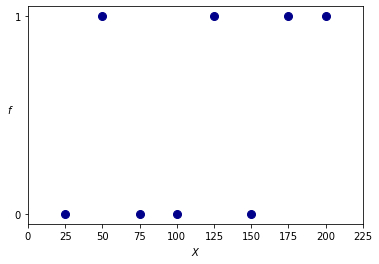

In [87]:
# save number of satisfactions for each population size and experiment
satisfactions = defaultdict(list)
pop_sizes = np.arange(25, 225, 25) 

# read outcomes for all population sizes and compute number of satisfactions
for dirpath, dirs, files in os.walk("/Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc"):
    for file in files:
        if file.startswith("sir"):
            p = int((file.split("_")[1]).split(".")[0])
            with open(os.path.join(dirpath, file), 'r') as f:
                data = f.readline()
                for last_line in f:
                    pass
                S = float(last_line)
                satisfactions[p].append(S)

# Training data
f = []
for key in sorted(satisfactions):
    f.append(satisfactions[key])

X = pop_sizes.reshape(-1,1)
N = len(X)
f = np.array(f).reshape(-1,1)

plt.figure(figsize=(6,4))
plt.plot(X, f, 'o', ms=8, color='darkblue')
plt.xlim((0, 225))
plt.yticks([0,1])
plt.xlabel('$X$')
plt.ylabel('$f$', rotation=0)
plt.savefig("../figures/sir/SIR_data_gpc.png", dpi=300)
#plt.show()


# Configuration
scale = 1  # number of trajectories per input point
paramValueSet = X # uncertain input parameter that is varied = population size
datapoints = len(paramValueSet)  # number of input points
paramValueOutputs = f # statistical outputs of satisfaction 

# for kernel
correction = 1e-4

# define default hyperparameters for all kernels
params = {'var': 0.5,
          'ell': 17}

## SIR read 10 observations data

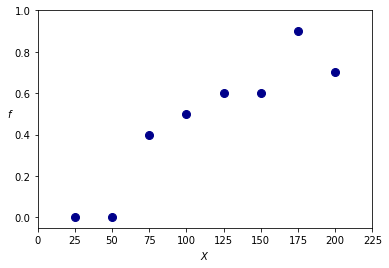

In [73]:
# save number of satisfactions for each population size and experiment
satisfactions = defaultdict(list)

# read outcomes for all population sizes and compute number of satisfactions
for dirpath, dirs, files in os.walk("/Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc2"):
    for file in files:
        if file.startswith("sir"):
            p = int((file.split("_")[1]).split(".")[0])
            with open(os.path.join(dirpath, file), 'r') as f:
                data = f.readline()
                for last_line in f:
                    pass
                S = float(last_line)
                satisfactions[p].append(S)

# Training data
f = []
for key in sorted(satisfactions):
    f.append(satisfactions[key])
    
X = pop_sizes.reshape(-1,1)
N = len(X)
f = np.array(f).reshape(-1,1)

plt.figure(figsize=(6,4))
plt.plot(X, f, 'o', ms=8, color='darkblue')
plt.xlim((0, 225))
plt.ylim((-0.05,1))
plt.xlabel('$X$')
plt.ylabel('$f$', rotation=0)
plt.savefig("../figures/sir/SIR_data_smc.png", dpi=300)
#plt.show()

# Configuration
scale = 10  # number of trajectories per input point
paramValueSet = X # uncertain input parameter that is varied = population size
datapoints = len(paramValueSet)  # number of input points
paramValueOutputs = f # statistical outputs of satisfaction 

# for kernel
correction = 1e-4

# define default hyperparameters for all kernels
params = {'var': 0.5,
          'ell': 17}

## SIR read PMC data

In [41]:
# save probability of satisfactions for each population size and experiment
true_satisfactions = defaultdict(list)

# read outcomes for all population sizes and compute number of satisfactions
for dirpath, dirs, files in os.walk("/Users/juliaklein/Documents/uni/MasterThesis/data/sir_gpc_true"):
    for file in files:
        if file.startswith("sir"):
            p = int((file.split("_")[1]).split(".")[0])
            with open(os.path.join(dirpath, file), 'r') as f:
                data = f.readline()
                for last_line in f:
                    pass
                S = float(last_line)
                true_satisfactions[p].append(S)

# "True" data (in the sense that we refer to the results of PMC)
true_f = []
for key in sorted(true_satisfactions):
    true_f.append(true_satisfactions[key])
    
true_X = np.arange(5, 250, 5).reshape(-1,1)
true_f = np.array(true_f).reshape(-1,1)


### How do we choose parameters of local approximating distributions $t_i$?  


**Algorithm** proceeds *iteratively*: update individual $t_i$ approximations sequentially until convergence (= all marginal distributions $q(f_i)$ are consistent with $\hat{p}(f_i)$ ):  
1. start from some current approximate posterior, from which we leave out a site index $i$ (remove approx. likelihood term corresponding to $i$, marginalise all other variables) $\rightarrow$ marginal *cavity distribution*    
2. Combine cavity distribution with exact likelihood $p(y_i|f_i)$ to get desired (non-Gaussian) marginal, or *tilted distribution*  
3. Update EP approximation by replacing the initial approximation likelihood term with the new term $\tilde{t}$ obtained by finding the Gaussian which matches the moments of the tilted distribution    
4. Apply iteratively to all sites until the moment of the EP approximation does not change   




In [88]:
# Prior
gauss_C = kernel_rbf(paramValueSet, paramValueSet, params) + correction * np.eye(datapoints) # covariance training set

gauss_LC_t = cholesky(gauss_C)  # cholesky decomposition, returns U from A=U'*U (U=L')
gauss_LC = gauss_LC_t.T  # transpose LC' 
gauss_LC_diag = np.diagonal(gauss_LC).reshape(-1,1)

logdet_LC = 2*np.sum(np.log(gauss_LC_diag))
logZprior = 0.5*logdet_LC

logZterms = np.zeros(datapoints).reshape(-1,1)
logZloo = np.zeros(datapoints).reshape(-1,1)
Term = np.zeros((datapoints, 2))  # Term = v_tilde, tau_tilde

# compute marginal moments mu and sigma^2
_, gauss_m, gauss_diagV = marginal_moments(Term, gauss_LC, gauss_LC_t)

# related to likelihood approximation
# true observation values (number of trajectories satisfying property)
gauss_LikPar_p = paramValueOutputs * scale
gauss_LikPar_q = scale - gauss_LikPar_p 

# gauss hermite: quadrature to approximate values of integral, returns abscissas (x) and weights (w) of
# n-point Gauss-Hermite quadrature formula
nodes = 96
gauss_xGauss, gauss_wGauss = gausshermite(nodes)
gauss_logwGauss = np.log(gauss_wGauss)

# configurations for loop initialization
MaxIter=1000
tol=1e-6
logZold=0
logZ = 2*tol
steps=0
logZappx=0
eps_damp=0.5

while (np.abs(logZ-logZold)>tol) and (steps<MaxIter):
    steps += 1
    logZold = logZ
    
    # find cavity distribution parameters mu_-i and sigma^2_-i
    cav_m, cav_diagV = cavities(gauss_diagV, gauss_m, Term)
    
    # update marginal moments mu_hat and sigma^2_hat, and site parameters v_tilde and tau_tilde
    Term, logZterms, logZloo = ep_update(cav_diagV, cav_m, Term, eps_damp, gauss_LikPar_p,
                      gauss_LikPar_q, gauss_xGauss, gauss_logwGauss)
    
    # recompute mu and sigma^2 from the updated parameters
    logZappx, gauss_m, gauss_diagV = marginal_moments(Term, gauss_LC, gauss_LC_t)
    
    logZ = logZterms.sum() + logZappx
    
    print("Iteration ", steps)
    
print("\nFinish")


Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19

Finish


### Finish Training  

$\tilde{\mu} = \tilde{v} * \frac{1}{\tilde{\tau}} $  

$\tilde{\Sigma}$ with diagonal $\tilde{\Sigma}_{ii} = \tilde{\sigma}^2$  

$invC = (C + \tilde{\Sigma})^{-1}$

In [89]:
v_tilde = Term[:,0].reshape(-1,1)
tau_tilde = Term[:,1].reshape(-1,1)

diagSigma_tilde = 1/tau_tilde

mu_tilde = np.multiply(v_tilde, diagSigma_tilde)

Sigma_tilde = np.zeros((datapoints, datapoints))
np.fill_diagonal(Sigma_tilde, diagSigma_tilde)

# inverse of K + Sigma_tilde
invC = np.linalg.solve((gauss_C + Sigma_tilde), np.eye(len(mu_tilde)))


### get GP Posterior


**Rasmussen 3.60, 3.61**  

Predictive mean for latent variable $f_*$: $\mathbb{E}_q[f_*|X,y,x_*] = k_*^T (K + \tilde{\Sigma})^{-1} \tilde{\mu}$   

Predictive variance: $\mathbb{V}_q[f_*|X,y,x_*] = k(x_*,x_*) - k_*^T (K + \tilde{\Sigma})^{-1} k_*$  


**Here:**  

$fs = (ks (C + \tilde{\Sigma})^{-1}) \tilde{\mu}$  

$vfs = kss - (ks (C + \tilde{\Sigma})^{-1} ) * ks^T$ 

## Testpoints for SIR to compute predictions

In [90]:
# define test set for which posterior is derived
testpoints = X_s = np.linspace(0, 250, 1000).reshape(-1,1)

# calculate variances of testset and covariances of test & training set (apply kernel)
kss = kernel_rbf(testpoints, testpoints, params) 
ks = kernel_rbf(testpoints, paramValueSet, params) 

# predictive mean 
fs = np.matmul(np.matmul(ks, invC), mu_tilde)

# predictive variance -> here only diagonal
vfs = (np.diagonal(kss) - (np.diagonal(np.matmul(np.matmul(ks, invC), ks.T)))).reshape(-1,1)

### Probit Regression Posterior
Compute confidence bounds and plot results  


**Rasmussen 3.63**   

Predictive probability $q(y_*=1|X,y,x_*) = \phi(\frac{\mathbb{E}_q[f_*|X,y,x_*]}{\sqrt{1 + \mathbb{V}_q[f_*|X,y,x_*]}})$

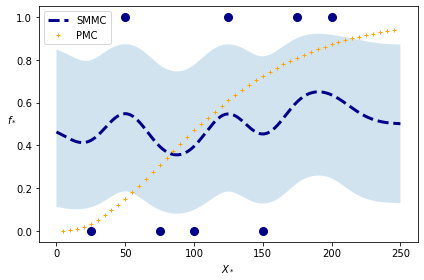

In [91]:
# function to compute probit values
def standardNormalCDF(x):
    return 1/2 + 1/2 * erf(x * (1/np.sqrt(2)))


cached_denominator = (1 / np.sqrt(1 + vfs)).reshape(-1,1)


# get probabilities with probit function
probabilities = standardNormalCDF(fs * cached_denominator)


# compute confidence bounds
lowerbound = standardNormalCDF((fs - 1.96 * np.sqrt(vfs).reshape(-1,1)) *
                              cached_denominator)
upperbound = standardNormalCDF((fs + 1.96 * np.sqrt(vfs).reshape(-1,1)) *
                              cached_denominator)

# plot data
fig = plt.figure(figsize=(6,4))
plt.plot(paramValueSet, paramValueOutputs, 'o', ms=8, c='darkblue')
plt.plot(testpoints, probabilities, lw=3, ls='--', c='darkblue', label='SMMC')
plt.fill_between(testpoints.ravel(), lowerbound.ravel(), upperbound.ravel(), alpha=0.2)
try: true_X
except NameError: true_X = None
if true_X is not None:
    plt.plot(true_X, true_f, '+', ms=4, c='orange', label='PMC')
#plt.title(f'Posterior with {scale} observations per input point')
plt.xlabel('$X_*$')
plt.ylabel('$f_*$', rotation=0)
plt.legend()
plt.ylim((-0.05, 1.05))
plt.tight_layout()        
plt.show()
#fig.savefig("../figures/sir/SIR_smmc_posterior10.png", dpi=300)

## Compute MSE

In [78]:
def calc_mse(x, x_s, f, probs):
    """ Compute MSE for posterior function of the training data points
    
    Parameters:
        x: Training data input
        x_s: Test data input 
        f: Training data output
        probs: computed probabilities (posterior)
        
    Returns:  
        mse: Average distance of predictions to true training data output
    """
    predictions = []
    for i in x:
        idx = np.absolute(x_s - i).argmin()
        predictions.append(probs[idx])

    mse = np.square(np.subtract(f.reshape(1,-1), predictions)).mean()

    return mse


mse = calc_mse(paramValueSet, testpoints, paramValueOutputs, probabilities)
print("MSE: ", mse)

MSE:  0.14536942441377657
